In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime as dt

# --- 1. LOAD DATA ---

# Paths to your files
path_prefix = '/content/drive/MyDrive/archive-2/Data_with_90_minutes/'
file_paths = {
    '19-20': '2019-20_weather_90_full.csv',
    '20-21': '2020-21_weather_90.csv',
    '21-22': '2021-22_weather_90.csv',
}

# Columns we need
columns_req = [
    'Date', 'Time',
    'HomeTeam', 'AwayTeam', 'FTR',
    'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST',
    'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR',
    'Start_Temp_C', 'Start_Wind_kmh', 'Start_Wind_Degree',
    'Start_Humidity', 'Start_Precip_mm', 'Start_Conditions', 'End_Conditions'
]

data_frames = []

# Load and prepare all CSVs
for key, file_path in file_paths.items():
    try:
        df = pd.read_csv(f"{path_prefix}{file_path}")
        df = df[columns_req]

        # Correct/unify date format
        df.loc[:,'Date'] = pd.to_datetime(df['Date'], #format='%d/%m/%y',
                                          errors='coerce', dayfirst=True)

        data_frames.append(df)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

# --- 2. CREATE SINGLE MASTER DATAFRAME ---

all_seasons_df = pd.concat(data_frames, ignore_index=True)
print(f'all seasons befor dropna: {all_seasons_df.shape}')
all_seasons_df = all_seasons_df.dropna(subset=['Date']) # Remove rows with invalid dates
all_seasons_df = all_seasons_df.sort_values(by='Date').reset_index(drop=True)
all_seasons_df['match_id'] = all_seasons_df.index


print(f"Data loaded and processed. Total shape: {all_seasons_df.shape}")
all_seasons_df.head(10)

all seasons befor dropna: (1140, 26)
Data loaded and processed. Total shape: (1140, 27)


,Date,Time,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HS,AS,HST,...,HR,AR,Start_Temp_C,Start_Wind_kmh,Start_Wind_Degree,Start_Humidity,Start_Precip_mm,Start_Conditions,End_Conditions,match_id
0,2019-08-09 00:00:00,20:00,Liverpool,Norwich,H,4,1,15,12,7,...,0,0,18.60,27.72,180,77,0.00,scattered clouds,overcast clouds,0
1,2019-08-10 00:00:00,12:30,West Ham,Man City,A,0,5,5,14,3,...,0,0,21.39,37.08,230,63,0.00,broken clouds,broken clouds,1
2,2019-08-10 00:00:00,15:00,Bournemouth,Sheffield United,D,1,1,13,8,3,...,0,0,19.14,46.44,250,74,0.00,broken clouds,scattered clouds,2
3,2019-08-10 00:00:00,15:00,Burnley,Southampton,H,3,0,10,11,4,...,0,0,16.33,25.38,236,96,2.29,moderate rain,moderate rain,3
4,2019-08-10 00:00:00,15:00,Crystal Palace,Everton,D,0,0,6,10,2,...,0,1,20.94,44.28,230,65,0.00,scattered clouds,scattered clouds,4
5,2019-08-10 00:00:00,15:00,Watford,Brighton,A,0,3,11,5,3,...,0,0,20.96,40.68,230,66,0.00,scattered clouds,broken clouds,5
6,2019-08-10 00:00:00,17:30,Tottenham,Aston Villa,H,3,1,31,7,7,...,0,0,20.54,31.68,220,63,0.00,broken clouds,few clouds,6
7,2019-08-11 00:00:00,14:00,Leicester,Wolves,D,0,0,15,8,1,...,0,0,17.62,18.11,260,69,0.00,overcast clouds,broken clouds,7
8,2019-08-11 00:00:00,14:00,Newcastle,Arsenal,A,0,1,9,8,2,...,0,0,14.03,11.16,40,99,0.82,light rain,light intensity drizzle rain,8
9,2019-08-11 00:00:00,16:30,Man United,Chelsea,H,4,0,11,18,5,...,0,0,16.30,22.32,270,77,0.00,broken clouds,shower rain,9


# One-hot encoding for weather data. Has to be changed to new csv with 90 minutes

In [ ]:
import pandas as pd

df_work = all_seasons_df.copy()

print("Starting weather processing for the current DataFrame...")

# 1. Classification Function
def map_weather_description(description):
    """
    Maps weather descriptions to a main category based on severity.
    Order: Dangerous -> Precipitation -> Visibility -> Clouds -> Clear
    """
    if pd.isna(description):
        return 'Unknown'

    # Convert to lowercase for easier comparison
    desc = str(description).lower()

    # 1. Thunderstorm (Highest Priority)
    if 'thunderstorm' in desc:
        return 'thunderstorm'

    # 2. Snow and Ice
    if 'snow' in desc or 'sleet' in desc or 'freezing' in desc:
        return 'snow'

    # 3. Heavy Rain
    if 'heavy' in desc or 'extreme' in desc or 'ragged' in desc:
        return 'heavy_rain'

    # 4. Moderate Rain / Showers
    if 'moderate' in desc or 'shower' in desc:
        return 'moderate_rain'

    # 5. Light Rain / Drizzle
    if 'rain' in desc or 'drizzle' in desc:
        return 'rain'

    # 6. Visibility (Fog/Mist)
    if 'mist' in desc or 'fog' in desc or 'haze' in desc:
        return 'fog'

    # 7. Clouds
    if 'clouds' in desc:
        return 'cloudy'

    # 8. Clear Sky
    if 'clear' in desc or 'sun' in desc:
        return 'clear_sky'

    # Fallback
    return 'Other'

# 2. Define the columns you want to process
target_columns = ['Start_Conditions', 'End_Conditions']

for col_name in target_columns:
    if col_name in df_work.columns:
        print(f"\n--- Processing column: '{col_name}' ---")

        # A) Categorize
        temp_cat_col = f'{col_name}_Category'
        df_work[temp_cat_col] = df_work[col_name].apply(map_weather_description)

        print(f"Distribution of weather categories for {col_name}:")
        print(df_work[temp_cat_col].value_counts())

        # B) One-Hot Encoding
        print(f"Applying One-Hot Encoding for {col_name}...")
        weather_features = pd.get_dummies(df_work[temp_cat_col], prefix=col_name, dtype=int)

        # C) Concatenate
        df_work = pd.concat([df_work, weather_features], axis=1)

        # D) Cleanup
        # Remove the original text column and the temporary category column
        df_work.drop([col_name, temp_cat_col], axis=1, inplace=True)

        print(f"Done! Created {weather_features.shape[1]} new numeric columns for {col_name}.")

    else:
        print(f"\nWARNING: Column '{col_name}' not found in DataFrame!")
        print("Available columns:", df_work.columns.tolist())

# Final check
print("\n------------------------------------------------")
print("Total columns after processing:", len(df_work.columns))
print("Finished.")

playing_stat = df_work

Starting weather processing for the current DataFrame...

--- Processing column: 'Start_Conditions' ---
Distribution of weather categories for Start_Conditions:
Start_Conditions_Category
cloudy           585
rain             234
clear_sky        208
moderate_rain     69
fog               34
snow               6
heavy_rain         3
thunderstorm       1
Name: count, dtype: int64
Applying One-Hot Encoding for Start_Conditions...
Done! Created 8 new numeric columns for Start_Conditions.

--- Processing column: 'End_Conditions' ---
Distribution of weather categories for End_Conditions:
End_Conditions_Category
cloudy           574
rain             234
clear_sky        219
moderate_rain     72
fog               30
heavy_rain         7
snow               4
Name: count, dtype: int64
Applying One-Hot Encoding for End_Conditions...
Done! Created 7 new numeric columns for End_Conditions.

------------------------------------------------
Total columns after processing: 40
Finished.


# Feature-Functions

In [ ]:
def classify_kickoff_time(df):
    """
    Classifies the kickoff time ('Time') into Afternoon (0) or Evening (1).
    Creates the 'TMKO' column.

    Logic:
    - 0 (Afternoon): Kickoff before 5 PM (17:00)
    - 1 (Evening): Kickoff at 5 PM (17:00) or later
    """

    df_out = df.copy()

    # --- STEP 0: Clean columns to prevent _x/_y suffixes ---
    # Find all columns starting with TMKO (TMKO, TMKO_x, TMKO_y)
    cols_to_drop = [col for col in df_out.columns if col.startswith('TMKO')]
    if cols_to_drop:
        df_out = df_out.drop(columns=cols_to_drop)

    # --- STEP 1: Extract hour ---
    # Ensures the 'Time' column is treated as datetime
    # and extracts the hour as a number (e.g., "16:30" -> 16)
    try:
        # Fill missing times (NaN) with '00:00' before conversion
        hour = pd.to_datetime(df_out['Time'].fillna('00:00'), format='%H:%M').dt.hour
    except ValueError as e:
        print(f"Error converting the 'Time' column: {e}")
        print("Ensure all times are in 'HH:MM' format (e.g., 16:30).")
        # Show a few problematic values
        print("Problem data (examples):")
        print(df_out[pd.to_datetime(df_out['Time'], format='%H:%M', errors='coerce').isna()]['Time'].head())
        return df # Return original DF if an error occurs

    # --- STEP 2: Classify ---
    df_out['TMKO'] = np.where(hour >= 17, 1, 0)

    return df_out

def get_strict_rolling_avg(df, stats_map, window_size=3):
    """
    Calculates the rolling average of the LAST 'window_size' matches.
    """

    # 1. Create a "long" version of the data
    generic_cols = list(stats_map.keys())
    home_df = df[['match_id', 'Date', 'HomeTeam'] + generic_cols].copy()
    home_df.rename(columns={'HomeTeam': 'Team'}, inplace=True)
    home_df['is_home_match'] = 1

    away_cols = list(stats_map.values())
    away_df = df[['match_id', 'Date', 'AwayTeam'] + away_cols].copy()
    away_df.rename(columns={'AwayTeam': 'Team'}, inplace=True)
    away_rename_map = dict(zip(away_cols, generic_cols))
    away_df.rename(columns=away_rename_map, inplace=True)
    away_df['is_home_match'] = 0

    # 2. Combine and sort by date
    all_stats_df = pd.concat([home_df, away_df], ignore_index=True)
    all_stats_df = all_stats_df.sort_values(by=['Team', 'Date'])

    # 3. Calculate and assign rolling average
    df_out = df.copy()

    # Prepare temporary DataFrames for home/away merges
    home_merge_df = all_stats_df[all_stats_df['is_home_match'] == 1][['match_id', 'Team']].copy()
    home_merge_df.rename(columns={'Team': 'HomeTeam'}, inplace=True)
    away_merge_df = all_stats_df[all_stats_df['is_home_match'] == 0][['match_id', 'Team']].copy()
    away_merge_df.rename(columns={'Team': 'AwayTeam'}, inplace=True)

    for home_stat, away_stat in stats_map.items():
        # 1. Calculate rolling avg (includes current match)
        rolling_avg_series = all_stats_df.groupby('Team')[home_stat].rolling(window=window_size).mean()
        rolling_avg_series = rolling_avg_series.reset_index(level=0, drop=True)

        # 2. Assign average as a *temporary* column
        all_stats_df['TEMP_AVG'] = rolling_avg_series

        # 3. Get the average value from the PREVIOUS row (.shift(1))
        all_stats_df['PREV_AVG'] = all_stats_df.groupby('Team')['TEMP_AVG'].shift(1)

        # --- 4. Merge back to "wide" format ---

        # Get home team data and rename column (e.g., 'AHST')
        home_data = all_stats_df[all_stats_df['is_home_match'] == 1][['match_id', 'PREV_AVG']]
        home_data = home_data.rename(columns={'PREV_AVG': f'A{home_stat}'})
        home_merge_df = home_merge_df.merge(home_data, on='match_id', how='left')

        # Get away team data and rename column (e.g., 'AAST')
        away_data = all_stats_df[all_stats_df['is_home_match'] == 0][['match_id', 'PREV_AVG']]
        away_data = away_data.rename(columns={'PREV_AVG': f'A{away_stat}'})
        away_merge_df = away_merge_df.merge(away_data, on='match_id', how='left')

    # --- 5. Final Merges ---
    df_out = df_out.merge(home_merge_df, on=['match_id', 'HomeTeam'], how='left')
    df_out = df_out.merge(away_merge_df, on=['match_id', 'AwayTeam'], how='left')

    return df_out


def get_previous_game_form(df):
    """
    Determines the result (Won/NotWin) of each team's last match.
    """

    # 1. Calculate result (Form) for each match from the team's perspective

    # --- Home Data ---
    home_df = df[['match_id', 'Date', 'HomeTeam', 'FTR']].copy()
    home_df.rename(columns={'HomeTeam': 'Team'}, inplace=True)
    home_df['is_home_match'] = 1
    home_df['Won'] = (home_df['FTR'] == 'H').astype(int)
    home_df['NotWin'] = (home_df['FTR'] != 'H').astype(int)

    # --- Away Data ---
    away_df = df[['match_id', 'Date', 'AwayTeam', 'FTR']].copy()
    away_df.rename(columns={'AwayTeam': 'Team'}, inplace=True)
    away_df['is_home_match'] = 0
    away_df['Won'] = (away_df['FTR'] == 'A').astype(int)
    away_df['NotWin'] = (away_df['FTR'] != 'A').astype(int)

    # 2. Combine and sort by date
    all_stats_df = pd.concat([home_df, away_df], ignore_index=True)
    all_stats_df = all_stats_df.sort_values(by=['Team', 'Date'])

    # 3. Create "Previous" form for each team
    all_stats_df['P_Won'] = all_stats_df.groupby('Team')['Won'].shift(1)
    all_stats_df['P_NotWin'] = all_stats_df.groupby('Team')['NotWin'].shift(1)

    # 4. Merge back to "wide" format
    df_out = df.copy()

    # Home teams
    home_prev_data = all_stats_df[all_stats_df['is_home_match'] == 1].copy()
    home_prev_data.rename(columns={'Team': 'HomeTeam', 'P_Won': 'PHFR_Won', 'P_NotWin': 'PHFR_NotWin'}, inplace=True)
    cols_to_merge_home = ['match_id', 'HomeTeam', 'PHFR_Won', 'PHFR_NotWin']
    df_out = df_out.merge(home_prev_data[cols_to_merge_home], on=['match_id', 'HomeTeam'], how='left')

    # Away teams
    away_prev_data = all_stats_df[all_stats_df['is_home_match'] == 0].copy()
    away_prev_data.rename(columns={'Team': 'AwayTeam', 'P_Won': 'PAFR_Won', 'P_NotWin': 'PAFR_NotWin'}, inplace=True)
    cols_to_merge_away = ['match_id', 'AwayTeam', 'PAFR_Won', 'PAFR_NotWin']
    df_out = df_out.merge(away_prev_data[cols_to_merge_away], on=['match_id', 'AwayTeam'], how='left')

    return df_out


def get_last_match_overall(df, stats_map):
    """
    Gets the stats of the last match for each team,
    regardless of venue (Home or Away).
    """

    # 1. Create a "long" version of the data
    generic_cols = list(stats_map.keys())
    home_df = df[['match_id', 'Date', 'HomeTeam'] + generic_cols].copy()
    home_df.rename(columns={'HomeTeam': 'Team'}, inplace=True)
    home_df['is_home_match'] = 1

    away_cols = list(stats_map.values())
    away_df = df[['match_id', 'Date', 'AwayTeam'] + away_cols].copy()
    away_df.rename(columns={'AwayTeam': 'Team'}, inplace=True)
    away_rename_map = dict(zip(away_cols, generic_cols))
    away_df.rename(columns=away_rename_map, inplace=True)
    away_df['is_home_match'] = 0

    # 2. Combine and sort by date
    all_stats_df = pd.concat([home_df, away_df], ignore_index=True)
    all_stats_df = all_stats_df.sort_values(by=['Team', 'Date'])

    # 3. Create "Previous" stats for each team
    prev_cols = {}
    for col in generic_cols:
        prev_cols[f'P_{col}'] = all_stats_df.groupby('Team')[col].shift(1)

    prev_stats_df = pd.DataFrame(prev_cols)
    all_stats_df = pd.concat([all_stats_df, prev_stats_df], axis=1)

    # 4. Merge back to "wide" format
    df_out = df.copy()

    # --- Merge for Home teams ---
    home_prev_data = all_stats_df[all_stats_df['is_home_match'] == 1].copy()
    home_prev_data.rename(columns={'Team': 'HomeTeam'}, inplace=True)
    # Rename columns: 'P_HST' -> 'PHST'
    home_rename_map = {f'P_{col}': f'P{col}' for col in generic_cols}
    home_prev_data.rename(columns=home_rename_map, inplace=True)
    cols_to_merge_home = ['match_id', 'HomeTeam'] + list(home_rename_map.values())
    df_out = df_out.merge(home_prev_data[cols_to_merge_home], on=['match_id', 'HomeTeam'], how='left')

    # --- Merge for Away teams ---
    away_prev_data = all_stats_df[all_stats_df['is_home_match'] == 0].copy()
    away_prev_data.rename(columns={'Team': 'AwayTeam'}, inplace=True)
    # Rename columns: 'P_HST' -> 'PAST' (uses the 'away_stat' name)
    away_rename_map = {}
    for home_stat, away_stat in stats_map.items():
        away_rename_map[f'P_{home_stat}'] = f'P{away_stat}' # e.g., 'P_HST' -> 'PAST'
    away_prev_data.rename(columns=away_rename_map, inplace=True)
    cols_to_merge_away = ['match_id', 'AwayTeam'] + list(away_rename_map.values())
    df_out = df_out.merge(away_prev_data[cols_to_merge_away], on=['match_id', 'AwayTeam'], how='left')

    return df_out



def get_time_between_games(df):
    """
    Calculates the number of days since the last match for
    the home and away teams (TBGH, TBGA).

    """

    df_out = df.copy()

    base_cols = ['TBGH', 'TBGA']

    cols_to_drop = []
    for col_in_df in df_out.columns:
        base_name = col_in_df.split('_x')[0].split('_y')[0]
        if base_name in base_cols:
            cols_to_drop.append(col_in_df)

    if cols_to_drop:
        df_out = df_out.drop(columns=list(set(cols_to_drop)))


    # 1.
    home_df = df_out[['match_id', 'Date', 'HomeTeam']].copy()
    home_df.rename(columns={'HomeTeam': 'Team'}, inplace=True)
    home_df['is_home_match'] = 1

    away_df = df_out[['match_id', 'Date', 'AwayTeam']].copy()
    away_df.rename(columns={'AwayTeam': 'Team'}, inplace=True)
    away_df['is_home_match'] = 0

    # 2.
    all_stats_df = pd.concat([home_df, away_df], ignore_index=True)
    all_stats_df = all_stats_df.sort_values(by=['Team', 'Date'])

    # 3.
    all_stats_df['Prev_Date'] = all_stats_df.groupby('Team')['Date'].shift(1)

    # Ensureing both columns are datetime objects before subtraction
    all_stats_df['Date'] = pd.to_datetime(all_stats_df['Date'], errors='coerce')
    all_stats_df['Prev_Date'] = pd.to_datetime(all_stats_df['Prev_Date'], errors='coerce')

    # b.
    all_stats_df['TBG'] = (all_stats_df['Date'] - all_stats_df['Prev_Date']).dt.days

    all_stats_df = all_stats_df.sort_values(by='Date')

    # 4.
    home_prev_data = all_stats_df[all_stats_df['is_home_match'] == 1].copy()
    home_prev_data.rename(columns={'Team': 'HomeTeam', 'TBG': 'TBGH'}, inplace=True)

    cols_to_merge_home = ['match_id', 'HomeTeam', 'TBGH']
    df_out = df_out.merge(
        home_prev_data[cols_to_merge_home],
        on=['match_id', 'HomeTeam'],
        how='left'
    )

    away_prev_data = all_stats_df[all_stats_df['is_home_match'] == 0].copy()
    away_prev_data.rename(columns={'Team': 'AwayTeam', 'TBG': 'TBGA'}, inplace=True)

    cols_to_merge_away = ['match_id', 'AwayTeam', 'TBGA']
    df_out = df_out.merge(
        away_prev_data[cols_to_merge_away],
        on=['match_id', 'AwayTeam'],
        how='left'
    )

    return df_out


def get_number_of_wins(df, window_size=3):
    """
    Calculates the *number* of wins in the last 'window_size' games
    (NOWH, NOWA).

    """

    df_out = df.copy()

    base_cols = ['NOWH', 'NOWA']

    cols_to_drop = []
    for col_in_df in df_out.columns:
        base_name = col_in_df.split('_x')[0].split('_y')[0]
        if base_name in base_cols:
            cols_to_drop.append(col_in_df)

    if cols_to_drop:
        df_out = df_out.drop(columns=list(set(cols_to_drop)))


    # 1.
    home_df = df_out[['match_id', 'Date', 'HomeTeam', 'FTR']].copy()
    home_df.rename(columns={'HomeTeam': 'Team'}, inplace=True)
    home_df['is_home_match'] = 1
    home_df['Won'] = (home_df['FTR'] == 'H').astype(int)

    away_df = df_out[['match_id', 'Date', 'AwayTeam', 'FTR']].copy()
    away_df.rename(columns={'AwayTeam': 'Team'}, inplace=True)
    away_df['is_home_match'] = 0
    away_df['Won'] = (away_df['FTR'] == 'A').astype(int)

    # 2. concate and sort
    all_stats_df = pd.concat([home_df, away_df], ignore_index=True)
    all_stats_df = all_stats_df.sort_values(by=['Team', 'Date'])

    # 3. Calculate the rolling *sum* of wins
    rolling_sum_series = all_stats_df.groupby('Team')['Won'] \
                                     .rolling(window=window_size) \
                                     .sum()
    rolling_sum_series = rolling_sum_series.reset_index(level=0, drop=True)

    all_stats_df['TEMP_NOW'] = rolling_sum_series

    all_stats_df['NOW'] = all_stats_df.groupby('Team')['TEMP_NOW'].shift(1)

    # 4. sort back
    all_stats_df = all_stats_df.sort_values(by='Date')

    # 5. Merge back

    home_prev_data = all_stats_df[all_stats_df['is_home_match'] == 1].copy()
    home_prev_data.rename(columns={'Team': 'HomeTeam', 'NOW': 'NOWH'}, inplace=True)

    cols_to_merge_home = ['match_id', 'HomeTeam', 'NOWH']
    df_out = df_out.merge(
        home_prev_data[cols_to_merge_home],
        on=['match_id', 'HomeTeam'],
        how='left'
    )

    away_prev_data = all_stats_df[all_stats_df['is_home_match'] == 0].copy()
    away_prev_data.rename(columns={'Team': 'AwayTeam', 'NOW': 'NOWA'}, inplace=True)

    cols_to_merge_away = ['match_id', 'AwayTeam', 'NOWA']
    df_out = df_out.merge(
        away_prev_data[cols_to_merge_away],
        on=['match_id', 'AwayTeam'],
        how='left'
    )

    df_out = df_out.drop(columns=['NOWH_x', 'NOWA_x', 'NOWH_y', 'NOWA_y'], errors='ignore')

    return df_out


def get_avg_time_between_games(df, window_size=3):
    """
    Calculates the *average* number of days since the
    last 'window_size' games (ATBGH, ATBGA).

    """

    df_out = df.copy()

    base_cols = ['ATBGH', 'ATBGA']

    cols_to_drop = []
    for col_in_df in df_out.columns:
        base_name = col_in_df.split('_x')[0].split('_y')[0]
        if base_name in base_cols:
            cols_to_drop.append(col_in_df)

    if cols_to_drop:
        df_out = df_out.drop(columns=list(set(cols_to_drop)))


    # 1. Create long version
    home_df = df_out[['match_id', 'Date', 'HomeTeam']].copy()
    home_df.rename(columns={'HomeTeam': 'Team'}, inplace=True)
    home_df['is_home_match'] = 1

    away_df = df_out[['match_id', 'Date', 'AwayTeam']].copy()
    away_df.rename(columns={'AwayTeam': 'Team'}, inplace=True)
    away_df['is_home_match'] = 0

    # 2. Concate and sort
    all_stats_df = pd.concat([home_df, away_df], ignore_index=True)
    all_stats_df = all_stats_df.sort_values(by=['Team', 'Date'])

    # 3. Calculate 'TBG' (Time Between Games)
    all_stats_df['Prev_Date'] = all_stats_df.groupby('Team')['Date'].shift(1)

    # Ensureing both columns are datetime objects before subtraction
    all_stats_df['Date'] = pd.to_datetime(all_stats_df['Date'], errors='coerce')
    all_stats_df['Prev_Date'] = pd.to_datetime(all_stats_df['Prev_Date'], errors='coerce')

    all_stats_df['TBG'] = (all_stats_df['Date'] - all_stats_df['Prev_Date']).dt.days.fillna(110)

    # 4. Applying rolling averages 'TBG' anwenden
    rolling_avg_series = all_stats_df.groupby('Team')['TBG'] \
                                     .rolling(window=window_size) \
                                     .mean()
    rolling_avg_series = rolling_avg_series.reset_index(level=0, drop=True)

    all_stats_df['TEMP_ATBG'] = rolling_avg_series

    all_stats_df['ATBG'] = all_stats_df.groupby('Team')['TEMP_ATBG'].shift(1)

    # 5. sort back
    all_stats_df = all_stats_df.sort_values(by='Date')

    # 6. merge back

    home_prev_data = all_stats_df[all_stats_df['is_home_match'] == 1].copy()
    home_prev_data.rename(columns={'Team': 'HomeTeam', 'ATBG': 'ATBGH'}, inplace=True)

    cols_to_merge_home = ['match_id', 'HomeTeam', 'ATBGH']
    df_out = df_out.merge(
        home_prev_data[cols_to_merge_home],
        on=['match_id', 'HomeTeam'],
        how='left'
    )

    away_prev_data = all_stats_df[all_stats_df['is_home_match'] == 0].copy()
    away_prev_data.rename(columns={'Team': 'AwayTeam', 'ATBG': 'ATBGA'}, inplace=True)

    cols_to_merge_away = ['match_id', 'AwayTeam', 'ATBGA']
    df_out = df_out.merge(
        away_prev_data[cols_to_merge_away],
        on=['match_id', 'AwayTeam'],
        how='left'
    )

    df_out = df_out.drop(columns=['TBGH_x', 'TBGA_x', 'TBGH_y', 'TBGA_y'], errors='ignore')

    return df_out

Additional features

In [ ]:
import pandas as pd
import numpy as np

def calculate_ewma_momentum(df, span=3):
    """
    Calculates momentum using Exponentially Weighted Moving Average of points.

    Args:
        df: The dataframe containing match statistics.
        span: The span (window size equivalent) for the EWMA.
              A span of 3 roughly corresponds to the 'center of mass' of a 3-match window.

    Returns:
        df: The dataframe with new columns 'HomeMomentum' and 'AwayMomentum'.
    """
    df = df.copy()

    # 1. Create a long-format dataframe of all matches from the team's perspective
    # Home Stats
    home_df = df[['Date', 'HomeTeam', 'FTR']].rename(columns={'HomeTeam': 'Team'})
    home_df['Points'] = np.where(df['FTR'] == 'H', 3,
                                 np.where(df['FTR'] == 'D', 1, 0))
    home_df['IsHome'] = True
    home_df['MatchIndex'] = df.index

    # Away Stats
    away_df = df[['Date', 'AwayTeam', 'FTR']].rename(columns={'AwayTeam': 'Team'})
    away_df['Points'] = np.where(df['FTR'] == 'A', 3,
                                 np.where(df['FTR'] == 'D', 1, 0))
    away_df['IsHome'] = False
    away_df['MatchIndex'] = df.index

    # Concatenate to get a single timeline per team
    teams_df = pd.concat([home_df, away_df]).sort_values(['Team', 'Date'])

    # 2. Calculate EWMA Momentum
    teams_df['Momentum_EWMA'] = teams_df.groupby('Team')['Points'].transform(
        lambda x: x.ewm(span=span, adjust=False).mean().shift(1)
    )

    # 3. Merge back into the original dataframe structure
    # Retrieve Home Momentum
    home_momentum = teams_df[teams_df['IsHome'] == True].set_index('MatchIndex')['Momentum_EWMA']
    df['HomeMomentum'] = home_momentum

    # Retrieve Away Momentum
    away_momentum = teams_df[teams_df['IsHome'] == False].set_index('MatchIndex')['Momentum_EWMA']
    df['AwayMomentum'] = away_momentum

    # Fill NaN values (first match of the season) with a default (e.g., 1 point or 0)
    df[['HomeMomentum', 'AwayMomentum']] = df[['HomeMomentum', 'AwayMomentum']].fillna(1)

    return df

In [ ]:
import pandas as pd
import numpy as np

def add_travel_distance_feature(df, coords_dict):
    """
    Adds a column to the DataFrame for the away team's travel distance.
    Assumeing the home team has a travel distance of 0.
    """

    # 1. Help function: Haversine-Formel for Distance on earth
    def haversine_np(lon1, lat1, lon2, lat2):
        """
        Calculates the great circle distance between two points
        on Earth (given in decimal degrees).
        """
        # Calculating to radius
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

        # Haversine-Formel
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        km = 6371 * c  # Radius of earth in km
        return km

    # 2. Coordinates mapping

    # Heim-Coordinates
    df['HomeLat'] = df['HomeTeam'].map(lambda x: coords_dict.get(x, (np.nan, np.nan))[0])
    df['HomeLon'] = df['HomeTeam'].map(lambda x: coords_dict.get(x, (np.nan, np.nan))[1])

    # Auswärts-Coordinates
    df['AwayLat'] = df['AwayTeam'].map(lambda x: coords_dict.get(x, (np.nan, np.nan))[0])
    df['AwayLon'] = df['AwayTeam'].map(lambda x: coords_dict.get(x, (np.nan, np.nan))[1])

    # 3. Calculate distance
    df['AwayDistTravelled'] = haversine_np(
        df['HomeLon'], df['HomeLat'],
        df['AwayLon'], df['AwayLat']
    )

    if df['AwayDistTravelled'].isna().sum() > 0:
        mean_dist = df['AwayDistTravelled'].mean()
        print(f"Warning: {df['AwayDistTravelled'].isna().sum()} missing distance is average of all({mean_dist:.2f} km).")
        df['AwayDistTravelled'].fillna(mean_dist, inplace=True)

    # 4. Clean up
    df.drop(['HomeLat', 'HomeLon', 'AwayLat', 'AwayLon'], axis=1, inplace=True)

    return df

stadium_coordinates = {
    "Arsenal": (51.555, -0.1086),
    "Bournemouth": (50.735, -1.838),
    "Brighton": (50.862, -0.083),
    "Burnley": (53.789, -2.230),
    "Chelsea": (51.4816, -0.1908),
    "Crystal Palace": (51.3983, -0.0855),
    "Everton": (53.4389, -2.9664),
    "Huddersfield": (53.654, -1.768),
    "Leicester": (52.6203, -1.1422),
    "Liverpool": (53.4308, -2.9608),
    "Man City": (53.4830, -2.2002),
    "Man United": (53.4631, -2.2913),
    "Newcastle": (54.9756, -1.6217),
    "Southampton": (50.9058, -1.3911),
    "Stoke": (52.9883, -2.1755),
    "Swansea": (51.6422, -3.9347),
    "Tottenham": (51.6042, -0.0662),
    "Watford": (51.6497, -0.4014),
    "West Brom": (52.5091, -1.9639),
    "West Ham": (51.5386, -0.0165),
    "Cardiff": (51.4728, -3.2031),
    "Fulham": (51.4749, -0.2217),
    "Wolves": (52.5902, -2.1303),
    "Aston Villa": (52.5091, -1.8847),
    "Norwich": (52.6222, 1.3092),
    "Sheffield United": (53.3703, -1.4708),
    "Leeds": (53.7778, -1.5722),
    "Brentford": (51.490833, -0.288611)
}


Pipeline to create the dataFrame

In [ ]:
def feature_engineering_pipeline(input_df, window_size=3):
    """
    Executes all feature engineering steps sequentially.
    """

    print(f"Starting pipeline with {input_df.shape[0]} matches...")
    df = input_df.copy()

    # --- 1. Define Stat-Mapping ---
    # (Home Stat : Away Stat)
    avg_stats_map = {
        'FTHG': 'FTAG',
        'HS': 'AS',
        'HST': 'AST',
        'HC': 'AC',
        'HF': 'AF',
        'HY': 'AY',
        'HR': 'AR'
    }

    # --- 2. Call functions sequentially ---

    print("Classifying kickoff time (TMKO)...")
    df = classify_kickoff_time(df)

    print("Calculating rolling average...")
    df = get_strict_rolling_avg(df, avg_stats_map, window_size=window_size)

    print("Calculating form (last match)...")
    df = get_previous_game_form(df)

    print("Calculating last match stats...")
    df = get_last_match_overall(df, avg_stats_map)

    print("Calculating time between games (TBGH, TBGA)...")
    df = get_time_between_games(df)

    print("Calculating number of wins in the last 3 games (NOWH, NOWA)")
    df = get_number_of_wins(df, window_size=window_size)

    print("claculation avarage time between games")
    df = get_avg_time_between_games(df, window_size=window_size)

    print("Calculating momentum through exponentially weighted moving averages")
    df = calculate_ewma_momentum(df, span=3)

    print("Calculationg fatigues with travel distance")
    df = add_travel_distance_feature(df, stadium_coordinates)

    print("Pipeline finished.")
    return df

In [ ]:
# --- 4. EXECUTE PIPELINE ---
features_df = feature_engineering_pipeline(playing_stat, window_size=3)
features_df.to_csv("features_df.csv", index= False)

# --- 5. CHECK RESULT ---

print("\n--- Result DataFrame Info ---")
features_df.info()

# Example columns to verify the result
print("\n--- Example Data (Mid-Season) ---")
example_cols = [
    'Time', 'TMKO',       #From classify_kickoff_time
    'HomeTeam', 'AwayTeam',
    'HST', 'AST',         # Original
    'AHST', 'AAST',      # From get_strict_rolling_avg
    'PHFR_Won', 'PAFR_Won', # From get_previous_game_form
    'PHST', 'PAST'        # From get_last_match_overall
]

# Show games from mid-season (should have values)
print(features_df[example_cols].iloc[100:105])

Starting pipeline with 1140 matches...
Classifying kickoff time (TMKO)...
Calculating rolling average...
Calculating form (last match)...
Calculating last match stats...
Calculating time between games (TBGH, TBGA)...
Calculating number of wins in the last 3 games (NOWH, NOWA)
claculation avarage time between games
Calculating momentum through exponentially weighted moving averages
Calculationg fatigues with travel distance
Pipeline finished.

--- Result DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 82 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Date                            1140 non-null   object 
 1   Time                            1140 non-null   object 
 2   HomeTeam                        1140 non-null   object 
 3   AwayTeam                        1140 non-null   object 
 4   FTR                             1140 non-null

In [ ]:
features_df.keys()

Index(['Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG', 'HS',
       'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR',
       'Start_Temp_C', 'Start_Wind_kmh', 'Start_Wind_Degree', 'Start_Humidity',
       'Start_Precip_mm', 'match_id', 'Start_Conditions_clear_sky',
       'Start_Conditions_cloudy', 'Start_Conditions_fog',
       'Start_Conditions_heavy_rain', 'Start_Conditions_moderate_rain',
       'Start_Conditions_rain', 'Start_Conditions_snow',
       'Start_Conditions_thunderstorm', 'End_Conditions_clear_sky',
       'End_Conditions_cloudy', 'End_Conditions_fog',
       'End_Conditions_heavy_rain', 'End_Conditions_moderate_rain',
       'End_Conditions_rain', 'End_Conditions_snow', 'TMKO', 'AFTHG', 'AHS',
       'AHST', 'AHC', 'AHF', 'AHY', 'AHR', 'AFTAG', 'AAS', 'AAST', 'AAC',
       'AAF', 'AAY', 'AAR', 'PHFR_Won', 'PHFR_NotWin', 'PAFR_Won',
       'PAFR_NotWin', 'PFTHG', 'PHS', 'PHST', 'PHC', 'PHF', 'PHY', 'PHR',
       'PFTAG', 'PAS', 'PAST', '

# Using features:


In [ ]:
basic_features = ['TMKO', 'AFTHG', 'AHS',
       'AHST', 'AHC', 'AHF', 'AHY', 'AHR', 'AFTAG', 'AAS', 'AAST', 'AAC',
       'AAF', 'AAY', 'AAR', 'PHFR_Won', 'PHFR_NotWin', 'PAFR_Won',
       'PAFR_NotWin', 'PFTHG', 'PHS', 'PHST', 'PHC', 'PHF', 'PHY', 'PHR',
       'PFTAG', 'PAS', 'PAST', 'PAC', 'PAF', 'PAY', 'PAR', 'TBGH', 'TBGA',
       'NOWH', 'NOWA',]

In [ ]:
weather_start = ['Start_Temp_C', 'Start_Wind_kmh', 'Start_Wind_Degree', 'Start_Humidity', 'Start_Precip_mm', 'Start_Conditions_clear_sky',
       'Start_Conditions_cloudy', 'Start_Conditions_fog',
       'Start_Conditions_heavy_rain', 'Start_Conditions_moderate_rain',
       'Start_Conditions_rain', 'Start_Conditions_snow',
       'Start_Conditions_thunderstorm',]

In [ ]:
weather_end = ['End_Conditions_clear_sky',
       'End_Conditions_cloudy', 'End_Conditions_fog',
       'End_Conditions_heavy_rain', 'End_Conditions_moderate_rain',
       'End_Conditions_rain', 'End_Conditions_snow',]

In [ ]:
features_added = ['HomeMomentum', 'AwayMomentum', 'AwayDistTravelled']

In [ ]:
features = (basic_features
            + weather_start
            + weather_end
            + features_added
)

Most important features

In [ ]:
features = ['HomeMomentum','AAS','AHS','Start_Temp_C','AAR','AAF','AwayMomentum','AHF','AwayDistTravelled','PHC','Start_Humidity','PAST','AAST','TBGH','TBGA','PHS' ,'PHF','AFTHG','Start_Conditions_cloudy','AHC']

# Training, Testing

In [ ]:
# 1. Clean up to length
df_clean = features_df.dropna().copy()
df_clean.to_csv("clean_90.csv", index=False)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Ensure the date is in the correct format
df_clean['Date'] = pd.to_datetime(df_clean['Date'])

# 2. Create a target variable (1 = home win, 0 = no home win)
df_clean['HomeWin_Binary'] = df_clean['FTR'].apply(lambda x: 1 if x == 'H' else 0)

# 3. Chronological split (time separation)
split_date = '2021-08-12'

# Everything before or on August 13, 2021 is training.
train_df = df_clean[df_clean['Date'] <= split_date].copy()

# Everything after is testing
test_df = df_clean[df_clean['Date'] > split_date].copy()

print(f"Training till {split_date}: {len(train_df)} games")
print(f"Testing since {split_date}: {len(test_df)} games")

# 4. Assign features and targets
X_train = train_df[features]
y_train = train_df['HomeWin_Binary']

X_test = test_df[features]
# Adjusting for consistency with paper
X_test = X_test.iloc[27:]
y_test = test_df['HomeWin_Binary']
y_test = y_test.iloc[27:]

Training till 2021-08-12: 722 games
Testing since 2021-08-12: 377 games


In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((722, 20), (722,), (350, 20), (350,))

# Fitting the models

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, matthews_corrcoef, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn import svm
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

In [ ]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name="Modell"):
    # 1. Training
    model.fit(X_train, y_train)

    # 2. Prediction
    y_pred = model.predict(X_test)

    model_predictions[name] = y_pred

    # 3. Calculate metrcs
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)

    # 4. Results
    print(f"\n{'='*10} Results: {model_name} {'='*10}")
    print(f"TP (True home victory detected): {tp}")
    print(f"TN (No win detected): {tn}")
    print(f"FP (False alarm):          {fp}")
    print(f"FN (Missed home victory):           {fn}")
    print("-" * 30)
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"MCC:       {mcc:.4f}")
    print("\n=== Classification Report ===")
    print(classification_report(y_test, y_pred))

    return model

In [ ]:
# Definition of models

# Dictionary to store predictions for comparison
model_predictions = {}

models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(C=1.0, solver='liblinear'))
    ]),

    "Random Forest": RandomForestClassifier(
        max_depth=5,
        min_samples_split=2,
        min_samples_leaf=5,
        n_estimators= 50,
        max_features=0.8,
        max_samples= 1.0,
        random_state=42
    ),

    "SVM": Pipeline([
    ('scaler', StandardScaler()),
    ('svm', svm.SVC(C=0.1, class_weight= "balanced", kernel='rbf', gamma= 0.01, probability=True))
    ]),

    "XGBoost": XGBClassifier(
        n_estimators=150,
        learning_rate=0.01,
        max_depth=5,
        subsample=0.8,
        colsample_bytree = 1.0,
        reg_lambda = 10,
        random_state=42
    ),

    "Gradient Boosting (GBM)": GradientBoostingClassifier(
        max_depth=4,
        learning_rate= 0.1387,
        subsample=0.623,
        random_state=42
    ),

    "LightGBM": LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1387,
        num_leaves=42,
        min_child_samples=57,
        subsample=0.623,
        colsample_bytree=0.634,
        reg_lambda=2.89,
        max_depth=-4,
        random_state=42,
        verbose=-1
    ),
    "CatBoost": CatBoostClassifier(
        depth=10,
        l2_leaf_reg=9,
        learning_rate=0.03,
        verbose=False
    )
}

# Loop over all models
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    trained_model = train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name=name)
    results[name] = trained_model

Training Logistic Regression...

========== Results: Logistic Regression ==========
TP (True home victory detected): 61
TN (No win detected): 158
FP (False alarm):          43
FN (Missed home victory):           88
------------------------------
Accuracy:  0.6257
Precision: 0.5865
Recall:    0.4094
F1-Score:  0.4822
MCC:       0.2115

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.64      0.79      0.71       201
           1       0.59      0.41      0.48       149

    accuracy                           0.63       350
   macro avg       0.61      0.60      0.59       350
weighted avg       0.62      0.63      0.61       350

Training Random Forest...

========== Results: Random Forest ==========
TP (True home victory detected): 54
TN (No win detected): 166
FP (False alarm):          35
FN (Missed home victory):           95
------------------------------
Accuracy:  0.6286
Precision: 0.6067
Recall:    0.3624
F1-Score:  0.4538


# Ensemble

In [ ]:
# Group 1
estimators_all = [
    ('lr', models['Logistic Regression']),
    ('rf', models['Random Forest']),
    ('svm', models['SVM']),
    ('xgb', models['XGBoost']),
    ('gbm', models['Gradient Boosting (GBM)'])
]

# Group 2
estimators_subset = [
    ('lr', models['Logistic Regression']),
    ('svm', models['SVM']),
    ('lgbm', models['LightGBM'],)
]

estimators_all_new = [
    ('lr', models['Logistic Regression']),
    ('rf', models['Random Forest']),
    ('svm', models['SVM']),
    ('xgb', models['XGBoost']),
    ('gbm', models['Gradient Boosting (GBM)']),
    ('cat', models['CatBoost'])
]

In [ ]:
# Stacking
stack_all = StackingClassifier(
    estimators=estimators_all,
    final_estimator= LogisticRegression(),
    #final_estimator = svm.SVC(C=0.1, class_weight= "balanced", kernel='rbf', gamma= 0.01, probability=True),
    cv=5
)

# Voting
vote_all = VotingClassifier(
    estimators=estimators_all,
    voting='hard'
)


# --- Szenario 2: Subset (LR, SVM, LightGBM) ---

# Stacking
stack_subset = StackingClassifier(
    estimators=estimators_subset,
    final_estimator=LogisticRegression(),
    #final_estimator = svm.SVC(C=0.1, class_weight= "balanced", kernel='rbf', gamma= 0.01, probability=True),
    cv=5
)

# Voting
vote_subset = VotingClassifier(
    estimators=estimators_subset,
    voting='hard'
)



In [ ]:
# Option 3: All+new
stack_all_new = StackingClassifier(
    estimators=estimators_all_new,
    final_estimator=LogisticRegression(),
    #final_estimator = svm.SVC(C=0.1, class_weight= "balanced", kernel='rbf', gamma= 0.01, probability=True),
    cv=5
)

# Voting
vote_all_new = VotingClassifier(
    estimators=estimators_all_new,
    voting='hard'
)

In [ ]:
ensemble_models = {
    "Stacking (All)": stack_all,
    "Voting (All)": vote_all,
    "Stacking (Subset)": stack_subset,
    "Voting (Subset)": vote_subset,
    "Stacking (All+new)": stack_all_new,
    "Voting (All+new)": vote_all_new
}

models.update(ensemble_models)

# Results

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

# 1. empty list for results
results = []

print("Start training of models...")

for name, model in models.items():
    # Training
    model.fit(X_train, y_train)

    # prediction
    y_pred = model.predict(X_test)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=1)
    rec = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    mcc = matthews_corrcoef(y_test, y_pred)

    # save results
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "MCC": mcc
    })


df_results = pd.DataFrame(results)

df_results = df_results.round(4)

transposed = df_results.transpose()
transposed.to_csv("results_best_features.csv", index=True)

# show table
display(transposed)

Start training of models...


,0,1,2,3,4,5,6,7,8,9,10,11,12
Model,Logistic Regression,Random Forest,SVM,XGBoost,Gradient Boosting (GBM),LightGBM,CatBoost,Stacking (All),Voting (All),Stacking (Subset),Voting (Subset),Stacking (All+new),Voting (All+new)
Accuracy,0.6257,0.6286,0.6086,0.6629,0.5971,0.6229,0.62,0.6229,0.6571,0.6057,0.6343,0.6286,0.6343
Precision,0.5865,0.6067,0.5341,0.7183,0.5303,0.5659,0.5833,0.6441,0.6381,0.6,0.5827,0.661,0.6154
Recall,0.4094,0.3624,0.6309,0.3423,0.4698,0.4899,0.3758,0.255,0.4497,0.2215,0.4966,0.2617,0.3758
F1-Score,0.4822,0.4538,0.5785,0.4636,0.4982,0.5252,0.4571,0.3654,0.5276,0.3235,0.5362,0.375,0.4667
MCC,0.2115,0.2138,0.2204,0.2985,0.1646,0.2166,0.196,0.1988,0.2812,0.1522,0.2396,0.2143,0.2274


In [ ]:
import shap

# Use a small background sample
background_data = shap.sample(X_train, 50)

# CHANGE: Use 'model.predict' instead of 'model.predict_proba'
explainer = shap.KernelExplainer(model.predict, background_data)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Plot
shap.summary_plot(shap_values, X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


  0%|          | 0/344 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist

KeyboardInterrupt: 

# Statistical Testing

In [ ]:
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.contingency_tables import mcnemar

# 1. Setup storage for p-values
model_names = list(model_predictions.keys())
p_values_df = pd.DataFrame(index=model_names, columns=model_names)

print(f"Comparing {len(model_names)} models pairwise...")

# 2. Iterate through every unique pair of models
for model_a, model_b in itertools.combinations(model_names, 2):
    # Retrieve predictions
    y_pred_a = model_predictions[model_a]
    y_pred_b = model_predictions[model_b]

    # Calculate Correct/Incorrect masks
    correct_a = (y_pred_a == y_test)
    correct_b = (y_pred_b == y_test)

    # Calculate McNemar's Contingency Cells
    # b: A is correct, B is wrong
    # c: A is wrong, B is correct
    a = sum(correct_a & correct_b)        # Both correct
    b = sum(correct_a & ~correct_b)       # A correct, B wrong
    c = sum(~correct_a & correct_b)       # A wrong, B correct
    d = sum(~correct_a & ~correct_b)      # Both wrong

    table = [[a, b], [c, d]]

    # Run Test
    result = mcnemar(table, exact=True)

    # Store result in the DataFrame (symmetric matrix)
    p_values_df.loc[model_a, model_b] = result.pvalue
    p_values_df.loc[model_b, model_a] = result.pvalue

# Fill diagonal with 1.0
p_values_df.fillna(1.0, inplace=True)

# 3. Output Significant Results
print("\nStatistically Significant Differences (p < 0.05):")
significant_found = False
for model_a, model_b in itertools.combinations(model_names, 2):
    p_val = p_values_df.loc[model_a, model_b]
    if p_val < 0.05:
        print(f"{model_a} vs {model_b}: p-value = {p_val:.4f} (Significant)")
        significant_found = True

if not significant_found:
    print("No significant differences found between any models.")

Comparing 7 models pairwise...

Statistically Significant Differences (p < 0.05):
No significant differences found between any models.


/tmp/ipython-input-794051908.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  p_values_df.fillna(1.0, inplace=True)


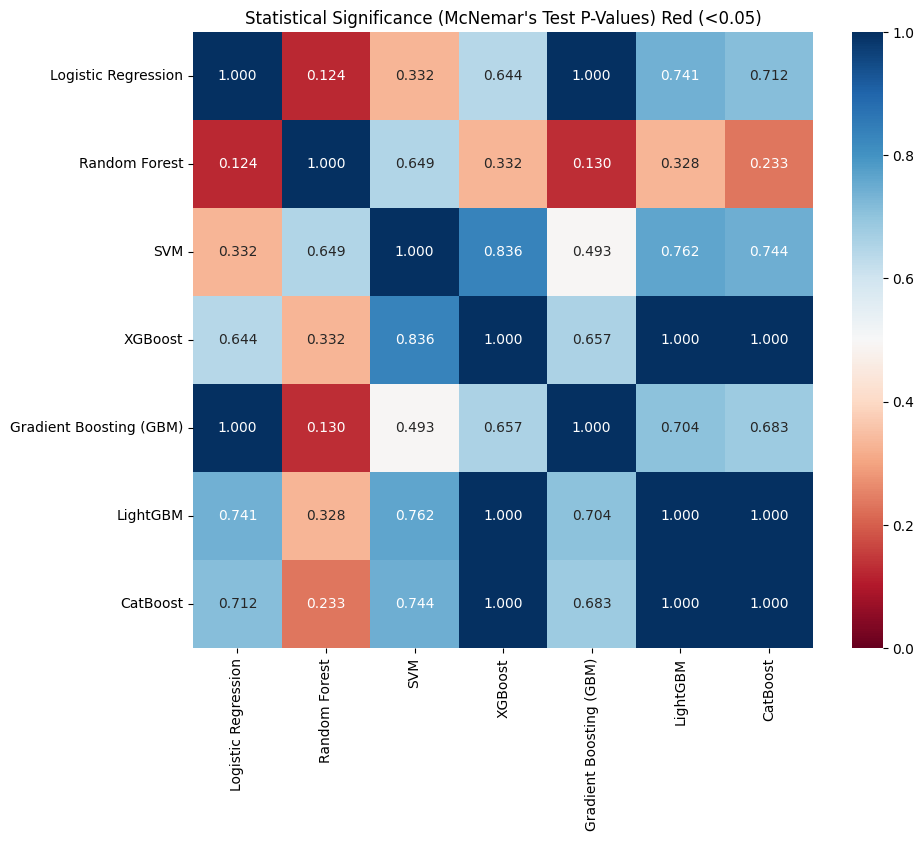

In [ ]:
# Create a heatmap to visualize the p-values
plt.figure(figsize=(10, 8))

p_values_float = p_values_df.astype(float)

# Red = Significant Difference (low p-value), Blue = No Difference
sns.heatmap(p_values_float, annot=True, fmt=".3f", cmap="RdBu", vmin=0, vmax=1.0)

plt.title("Statistical Significance (McNemar's Test P-Values) Red (<0.05)")
plt.show()